# Dog Breed Identification : Modèle AlexNet avec ImageDataGenerator

Nous allons utiliser le modèle AlexNet sur des données importées avec `ImageDataGenerator` en ajustant quelques hyper-paramètres.

## Préparation de l'environnement du travail

### Importation des packages

In [1]:
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

Regardons combien de GPUs disponible (que nous pouvons utiliser)

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Dézipper le fichier de données

In [2]:
zip_ref = zipfile.ZipFile("dog-breed-identification.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

### Récupération des données

Les données sont en deux parties: 
1. Le ficher `labels.csv` qui contient les `id` des images (le nom de fichier image sans extension) liés à leur modalité `breed`.
2. Le dossier `train` avec les images en format jpg.

Commençant par ajouter l'extension `.jpg` aux id des images dans `labels.csv` pour faciliter les tâches par la suite.

In [3]:
def append_ext(fn):
  return fn+".jpg"

In [4]:
df_train = pd.read_csv("/tmp/labels.csv")
df_train['id'] = df_train['id'].apply(append_ext)
labelNames = df_train["breed"].unique()
labelNames.shape

(120,)

Nous avons 120 types de chiens (120 modalités), et 10222 images dans le dossier train.

In [5]:
df_train.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07.jpg       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97.jpg             dingo
2  001cdf01b096e06d78e9e5112d419397.jpg          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d.jpg          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62.jpg  golden_retriever

## Création du modèle

Avant de passer à l'entraînement, nous allons formatez les images en `tensors` à virgule flottante en les prétraitant de la manière suivante :

1.   Lire les images du disque.
2.   Décoder le contenu de ces images et le convertir au format de grille approprié selon leur contenu RGB.
3.   Convertir les en `tensors` à virgule flottante des valeurs entre 0 et 255 à des valeurs comprises entre 0 et 1.
4.   Redimensionnez les images.

Ces étapes sont faites grâce à `ImageDataGenerator` de la bibliothèque `tf.keras`.

### Hyper-paramètres

Fixant quelques hyper-paramètres et les variables qui seront utilisés pour l'entraînement :

In [7]:
PATH = "/tmp/"
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')
batch_size = 128
epochs = 20
IMG_HEIGHT = 375
IMG_WIDTH = 500
IMG_SIZE = 227
learning_rate = 0.001
image_generator = ImageDataGenerator(rescale=1./255,
                                     validation_split=0.15,
                                     horizontal_flip=True,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     fill_mode="nearest"
                                    )

En créant l'instance d'ImageDataGenerator, nous avons présicé `rescale` pour normaliser les valeurs des pixels (0-255) à des valeurs (0-1).
La taille de validation dataset `validation_split` à 15%.
Pour augmenter les données, horizontal_flip est à True, width_shift_range et height_shift_range à 0.2. Avec fill_mode à `nearest` pour remplir le vide.

### Récupération des données (les images) avec ImageDataGenerator

In [8]:
train_data_gen = image_generator.flow_from_dataframe(dataframe=df_train,
                                                     batch_size=batch_size,
                                                     directory=train_dir,
                                                     x_col="id",
                                                     y_col="breed",
                                                     subset="training",
                                                     shuffle=True,
                                                     class_mode="categorical",
                                                     target_size=(IMG_SIZE, IMG_SIZE))

Found 8689 validated image filenames belonging to 120 classes.


In [9]:
valid_data_gen = image_generator.flow_from_dataframe(dataframe=df_train,
                                                     batch_size=batch_size,
                                                     directory=train_dir,
                                                     x_col="id",
                                                     y_col="breed",
                                                     subset="validation",
                                                     shuffle=True,
                                                     class_mode="categorical",
                                                     target_size=(IMG_SIZE, IMG_SIZE))

Found 1533 validated image filenames belonging to 120 classes.


In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

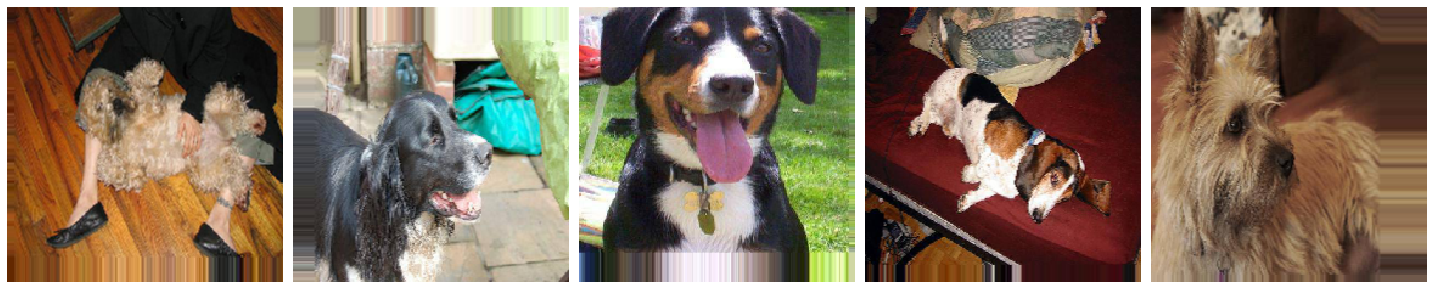

In [11]:
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images)

### Création du réseau de neurones `AlexNet`

In [12]:
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding="valid", activation = "relu"))

# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))

# Normalization
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same", activation = "relu"))

# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))

# Normalization
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))

# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))

# Normalization
model.add(BatchNormalization())

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(units = 9216, activation = "relu"))

# 2nd Fully Connected Layer
model.add(Dense(units = 4096, activation = "relu"))

# 3rd Fully Connected Layer
model.add(Dense(4096, activation = "relu"))

# Output Layer
model.add(Dense(120, activation = "softmax"))


model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 256)       1024      
____

Choisissons `accuracy` comme metrique et `Adam` comme optimisateur, avec learning_rate = 0.001 : 

In [13]:
opt = Adam(lr=learning_rate)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Entraînement du modèle : 

In [14]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=8689 // batch_size,
    epochs=epochs,
    validation_data=valid_data_gen,
    validation_steps=1533 // batch_size
)

Epoch 1/20
67/67 [==============================] - 108s 2s/step - loss: 5.6417 - acc: 0.0151 - val_loss: 5.1481 - val_acc: 0.0064
Epoch 2/20
67/67 [==============================] - 107s 2s/step - loss: 4.6506 - acc: 0.0225 - val_loss: 4.6885 - val_acc: 0.0185
Epoch 3/20
67/67 [==============================] - 107s 2s/step - loss: 4.5759 - acc: 0.0292 - val_loss: 13.7918 - val_acc: 0.0156
Epoch 4/20
67/67 [==============================] - 111s 2s/step - loss: 4.4915 - acc: 0.0332 - val_loss: 4.6120 - val_acc: 0.0305
Epoch 5/20
67/67 [==============================] - 103s 2s/step - loss: 4.4206 - acc: 0.0424 - val_loss: 4.6696 - val_acc: 0.0341
Epoch 6/20
67/67 [==============================] - 107s 2s/step - loss: 4.3438 - acc: 0.0492 - val_loss: 4.8034 - val_acc: 0.0234
Epoch 7/20
67/67 [==============================] - 112s 2s/step - loss: 4.2665 - acc: 0.0526 - val_loss: 4.6275 - val_acc: 0.0320
Epoch 8/20
67/67 [==============================] - 112s 2s/step - loss: 4.1909 - 

In [15]:
model.save("models/AlexNet/modelAlexNet2.h5")
with open('models/AlexNet/modelAlexNet2HistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

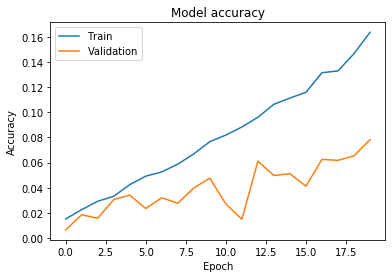

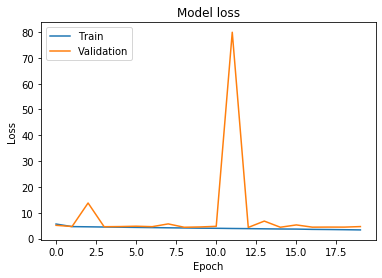

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()